In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
import matplotlib.pyplot as plt


In [27]:
# Load the data
data = pd.read_csv('../datasets/msft.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)

# Remove any rows with NaN values
data.dropna(inplace=True)
data.head(500)

         Date    Open   High    Low  Close    Volume
0  2014-01-02  37.350  37.40  37.10  37.16  30632200
1  2014-01-03  37.200  37.22  36.60  36.91  31134800
2  2014-01-06  36.850  36.89  36.11  36.13  43603700
3  2014-01-07  36.325  36.49  36.21  36.41  35802800
4  2014-01-08  36.000  36.14  35.58  35.76  59971700


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2014-03-14,37.651,38.135,37.5058,37.70,27195600,37.940,38.005,37.8600,37.0199,37.909261,37.921948,37.762257,37.373170,50.127877
50,2014-03-17,37.900,38.410,37.7900,38.05,20479600,37.986,38.032,37.8815,37.0377,37.956174,37.945230,37.789661,37.399713,56.204380
51,2014-03-18,38.260,39.900,38.2200,39.55,64063900,38.292,38.146,37.9880,37.0905,38.487449,38.237007,37.957312,37.484038,68.772563
52,2014-03-19,39.470,39.550,38.9100,39.27,35597200,38.492,38.262,38.0760,37.1533,38.748300,38.424824,38.082330,37.554076,62.983425
53,2014-03-20,39.250,40.649,39.2400,40.33,59269800,38.980,38.480,38.2050,37.2317,39.275533,38.771219,38.296394,37.662935,66.721854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2016-03-02,52.410,52.960,52.1550,52.95,29289884,51.962,51.901,51.2715,52.5779,52.161885,51.875563,51.776638,52.111062,66.430020
545,2016-03-03,52.970,52.970,51.7800,52.35,24427813,52.012,51.917,51.2810,52.5423,52.224590,51.961825,51.831244,52.120432,62.739464
546,2016-03-04,52.400,52.450,51.7100,52.03,33034150,52.158,51.938,51.2825,52.4863,52.159727,51.974220,51.850173,52.116886,57.688442
547,2016-03-07,51.560,51.800,50.5800,51.03,38428816,52.188,51.776,51.3260,52.3999,51.783151,51.802544,51.772062,52.074263,49.710425


In [28]:
feature_columns = [
    'Close',          
    'Low',            
    'High',          
    'Open',           
    'EMA for 5 days', 
    'MA for 5 days',  
    'RSI_14'   
]    

features = data[feature_columns].values

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 15  # 60-day window
X, y = create_sequences(scaled_data, seq_length)

# Split 80/20 chronologically
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(np.isnan(X_train).any(), np.isnan(y_train).any())
print(np.isinf(X_train).any(), np.isinf(y_train).any())

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

False False
False False
Training samples: 1978, Testing samples: 495
X_train shape: (1978, 15, 7), y_train shape: (1978,)


In [29]:
# Load the saved model
model = tf.keras.models.load_model('gru_lstm_model.keras')

c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [30]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
# Create dummy arrays to match the number of features for inverse scaling
y_pred_scaled = np.zeros((len(y_pred), len(feature_columns)))
y_pred_scaled[:, 0] = y_pred[:, 0]  # Place predictions in 'Close' column
y_pred = scaler.inverse_transform(y_pred_scaled)[:, 0]  # Extract 'Close'

y_test_scaled = np.zeros((len(y_test), len(feature_columns)))
y_test_scaled[:, 0] = y_test  # Place actual values in 'Close' column
y_test = scaler.inverse_transform(y_test_scaled)[:, 0]  # Extract 'Close'

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


RMSE: 9.94
MAE: 8.18
R^2: 0.95
MAPE: 2.75%


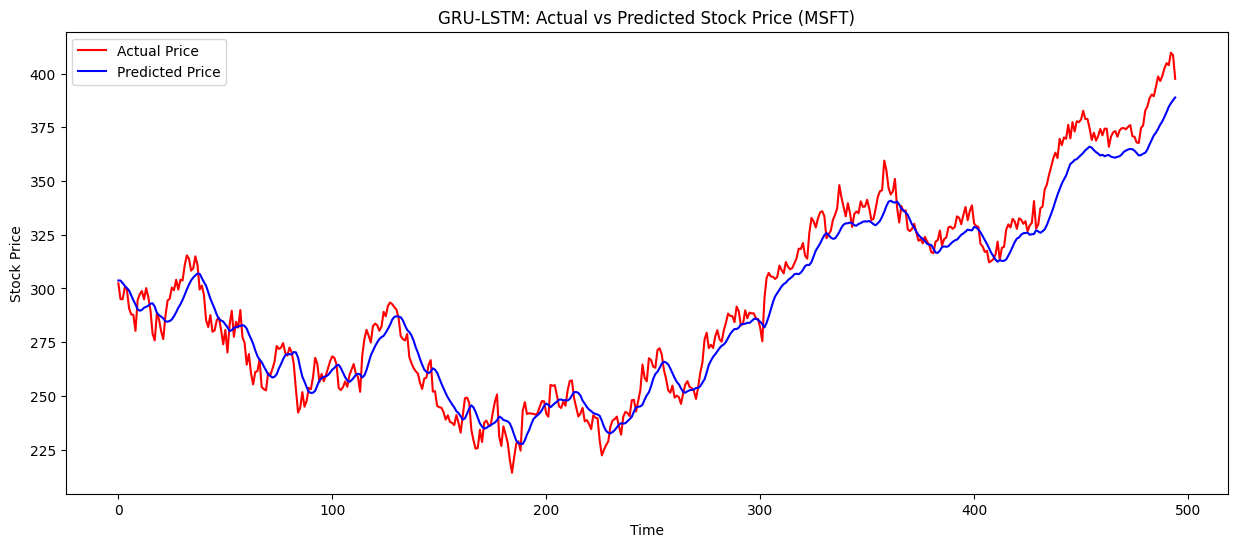

In [31]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R^2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

# Plot actual vs predicted prices
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Price', color='red')
plt.plot(y_pred, label='Predicted Price', color='blue')
plt.title('GRU-LSTM: Actual vs Predicted Stock Price (MSFT)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

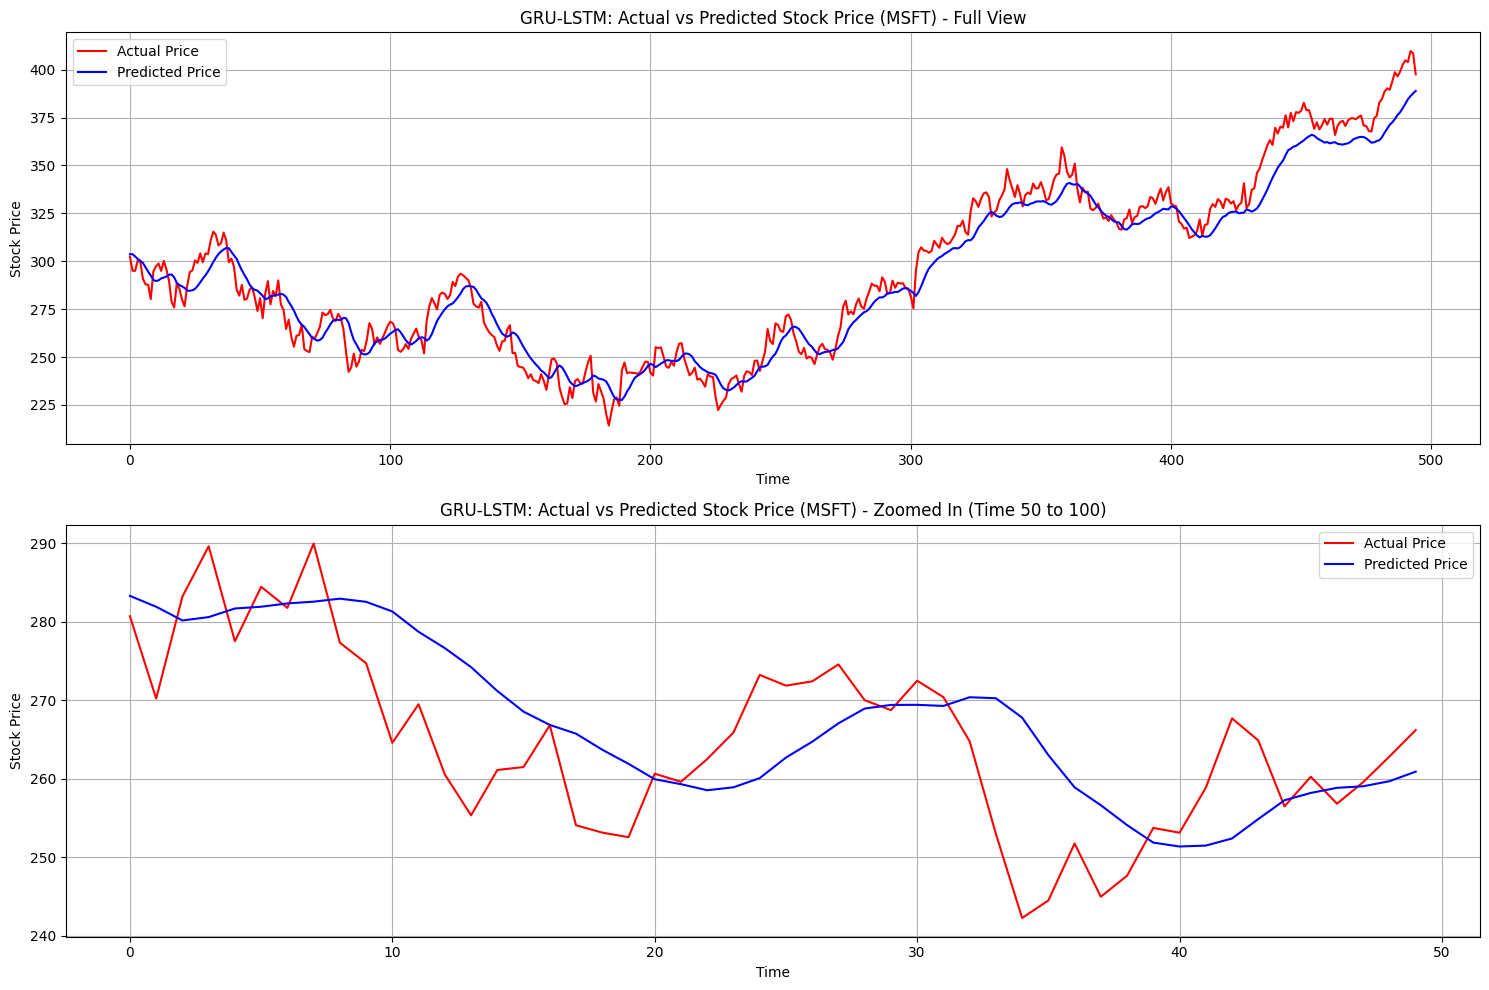

In [32]:
def plot_predictions_with_zoom(test_label, predicted, title="Actual vs Predicted Stock Price", zoom_start=50, zoom_end=100):
    plt.figure(figsize=(15, 10))

    # Full plot
    plt.subplot(2, 1, 1)
    plt.plot(test_label, label='Actual Price', color='red')
    plt.plot(predicted, label='Predicted Price', color='blue')
    plt.title(f"{title} - Full View")
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)

    # Zoomed-in plot to highlight short-term fluctuations
    plt.subplot(2, 1, 2)
    plt.plot(test_label[zoom_start:zoom_end], label='Actual Price', color='red')
    plt.plot(predicted[zoom_start:zoom_end], label='Predicted Price', color='blue')
    plt.title(f"{title} - Zoomed In (Time {zoom_start} to {zoom_end})")
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_predictions_with_zoom(y_test, y_pred, title="GRU-LSTM: Actual vs Predicted Stock Price (MSFT)", zoom_start=50, zoom_end=100)